# ResNet Ablation Study

## CIFAR-10 dataset


In [1]:
#!pip install tensorflow-datasets

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

* GPU 사용을 위한 하드웨어 세팅

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 다운로드

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_pregress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스 바가 나타나지 않습니다

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:90%]', 'train[90%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [5]:
# tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확ㅇ니하세요
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [6]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(20936, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


### Input Normalization
* resize
* normalization
* batch 설정 -> dataset 객체

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [64, 64])   # 이미지 크기 축소를 위한 resize
    return tf.cast(image, tf.float32) / 255., label   # 0-1 범위로 normalization

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features['label'].num_classes

2

In [10]:
ds_info.features['label'].names

['cat', 'dog']

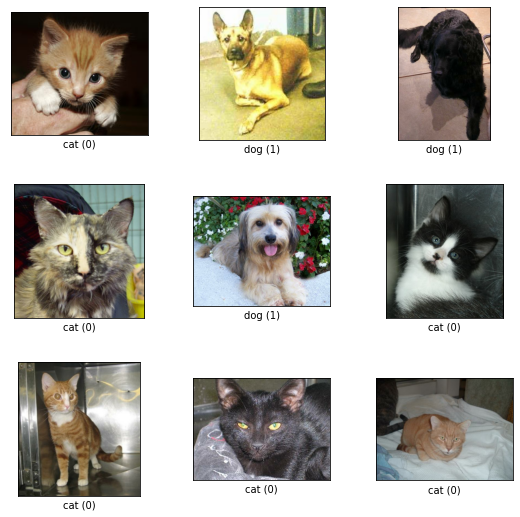

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

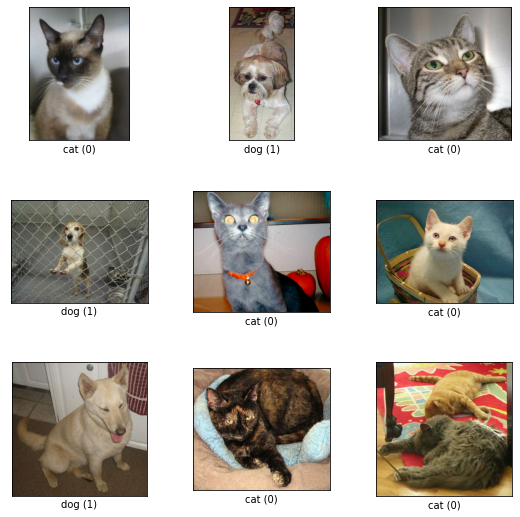

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

In [13]:
BATCH_SIZE = 256
EPOCH = 5

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:90%]', 'train[90%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

---
## ResNet 구현하기

## 블록 구성하기
딥러닝 모델의 주요 구조를 모듈화시켜 사용하는 단위\
레이어 + 레이어 + ... = 블록 block

### ResNet-34 VS ResNet-50
* Skip connection(or shortcut) 을 갖는 ResNet의 Identity block을 먼저 구성한다 -> 블록을 쌓아 전체 구조를 완성

* ResNet-34 는 7단의 레이어 -> ResNet-50 은 3단이 추가되어 10단 레이어로 기본 구성된다

* concatenate 과정에서 출력값과 채널 차원수가 다른 문제를 해결하기 위해, shortcut 에 Conv2D + BN 레이어를 추가한다.

In [15]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [16]:
# def identity_block(X, f, filters, stage, block):
#     '''
#     Implementation of the identity block as defined in Figure 3
    
#     Arguments:
#     X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
    
#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     '''
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value, You'll need this later to add block to the main path
#     X_shortcut = X
    
#     # First component of main path
#     X = Conv2D(F1, kernel_size=(1,1), strides=(1,1), 
#                padding='valid', 
#                name = conv_name_base + '2a', 
#                kernel_initializer = glorot_uniform(seed=0)
#               )(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
#     X = Activation('relu')(X)
    
#     # Second component of main path (=3 lines)
#     X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
#               padding='same',
#               name=conv_name_base + '2b',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
#     X = Activation('relu')(X)
    
#     # Third component of main path (=2 lines)
#     X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
#               padding='valid',
#               name=conv_name_base + '2b',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    
#     # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
#     return X

ValueError: Operands could not be broadcast together with shapes (32, 32, 256) (32, 32, 3)

* -> Shortcut과 출력값간의 채널 크기가 맞지않기 때문에 Conv2D + BN 추가

In [17]:
# def convolutional_block(X, f, filters, stage, block, s=2, is_50=False):
#     '''
#     Implementation of the identity block as defined in Figure 3
    
#     Arguments:
#     X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
#     s -- Integer, specifying the stride to be used
    
#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     '''
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value, You'll need this later to add block to the main path
#     X_shortcut = X
    
    
#     ### MAIN PATH ###
#     # First component of main path
#     X = Conv2D(F1, kernel_size=(1,1), strides=(s,s), 
#                padding='valid', 
#                name = conv_name_base + '2a', 
#                kernel_initializer = glorot_uniform(seed=0)
#               )(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
#     X = Activation('relu')(X)
    
#     # Second component of main path (=3 lines)
#     X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
#               padding='same',
#               name=conv_name_base + '2b',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
#     X = Activation('relu')(X)
    
#     # Third component of main path (=2 lines)
#     X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
#               padding='valid',
#               name=conv_name_base + '2c',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    
#     ### SHORTCUT PATH ###
#     X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),
#                         padding='valid',
#                         name = conv_name_base + '1',
#                         kernel_initializer = glorot_uniform(seed=0)
#                        )(X_shortcut)
#     X_shortcut = BatchNormalization(axis=3, name = bn_name_base + '1')(X_shortcut)

    
#     # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
#     return X

* 블록 구성을 확인하기위한 입-출력 설정 -> `model.summary()`

In [18]:
# resnet_input_layer = keras.layers.Input(shape=(32,32,3))
# resnet_block_output = convolutional_block(X=resnet_input_layer, f=3, filters=[64,64,256],  stage='34', block='1')

In [19]:
# model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)

# model.summary()

### Skip connection 을 갖는 ResNet-34, ResNet-50 클래스 구현
* `resnet34_block`, `resnet50_block`
* `plain34_block`, `plain50_block`

In [20]:
# def resnet34_block(X, f, filters, stage, block, s=2):
#     '''
#     Implementation of the identity block as defined in Figure 3
    
#     Arguments:
#     X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
#     s -- Integer, specifying the stride to be used
    
#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     '''
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value, You'll need this later to add block to the main path
#     X_shortcut = X
    
#     ### MAIN PATH ###
#     # First component of main path
#     X = Conv2D(F1, kernel_size=(1,1), strides=(s,s), 
#                padding='valid', 
#                name = conv_name_base + '2a', 
#                kernel_initializer = glorot_uniform(seed=0)
#               )(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
#     X = Activation('relu')(X)
    
#     # Second component of main path (=3 lines)
#     X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
#               padding='same',
#               name=conv_name_base + '2b',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
#     X = Activation('relu')(X)
    
#     # Third component of main path (=2 lines)
#     X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
#               padding='valid',
#               name=conv_name_base + '2c',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    
#     ### SHORTCUT PATH ###
#     X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),
#                         padding='valid',
#                         name = conv_name_base + '1',
#                         kernel_initializer = glorot_uniform(seed=0)
#                        )(X_shortcut)
#     X_shortcut = BatchNormalization(axis=3, name = bn_name_base + '1')(X_shortcut)

    
#     # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
#     return X

In [21]:
# def resnet50_block(X, f, filters, stage, block, s=2):
#     '''
#     Implementation of the identity block as defined in Figure 3
    
#     Arguments:
#     X -- input tensor of shape(m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
#     s -- Integer, specifying the stride to be used
    
#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     '''
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value, You'll need this later to add block to the main path
#     X_shortcut = X
    
#     ### MAIN PATH ###
#     # First component of main path
#     X = Conv2D(F1, kernel_size=(1,1), strides=(s,s), 
#                padding='valid', 
#                name = conv_name_base + '2a', 
#                kernel_initializer = glorot_uniform(seed=0)
#               )(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
#     X = Activation('relu')(X)
    
#     # Second component of main path (=3 lines)
#     X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1),
#               padding='same',
#               name=conv_name_base + '2b',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
#     X = Activation('relu')(X)
    
#     # Third component of main path (=2 lines)
#     X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
#               padding='valid',
#               name=conv_name_base + '2c',
#               kernel_initializer=glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    
#     ### SHORTCUT PATH ###
#     X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),
#                         padding='valid',
#                         name = conv_name_base + '1',
#                         kernel_initializer = glorot_uniform(seed=0)
#                        )(X_shortcut)
#     X_shortcut = BatchNormalization(axis=3, name = bn_name_base + '1')(X_shortcut)

    
#     # Final step: Add shortcut value to main path, and pass it through a ReLU activation (=2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
#     return X

* 위 코드 형식에서는 모델의 전체 구조를 파악하기 힘들고, 변수가 객체 별로 구분되기 어려운 점을 가지고 있다.\
따라서 클래스 함수화 형태로 사용할 수 있는 자료를 새로 찾아보았다.\
참고 : https://junstar92.tistory.com/146 ,\
https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb

---
## 비교실험에 유용한 객체화를 위해 클래스 함수 구현
### ResNet 구성
### ResNet-34 VS ResNet-50

In [22]:
class ResNet34_Block(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(ResNet34_Block, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        
        # skip_connect with conv layer to match dimension
        self.conv_skip = Conv2D(filters, kernel_size=(1,1), padding='valid')
        self.bn_skip = BatchNormalization()        
        
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        inputs = self.conv_skip(inputs)
        inputs = self.bn_skip(inputs)
        
        x = self.add([x, inputs])
        x = self.relu(x)
        
        return x

In [23]:
class ResNet50_Block(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(ResNet50_Block, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size=(1,1))
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size=(3,3), padding='same')
        self.bn2 = BatchNormalization()
        
        self.conv3 = Conv2D(filters*4, kernel_size=(1,1), padding='valid')
        self.bn3 = BatchNormalization()

        # skip_connect with conv layer to match dimension
        self.conv_skip = Conv2D(filters*4, kernel_size=(1,1), padding='valid')
        self.bn_skip = BatchNormalization()
        
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        # skip_connect with conv layer to match dimension
        inputs = self.conv_skip(inputs)
        inputs = self.bn_skip(inputs)
        
        x = self.add([x, inputs])
        x = self.relu(x)
        
        return x

In [24]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes, is_50=False):
        super(ResNet, self).__init__()
        self.conv = Conv2D(64, 7, strides=(2,2), padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))

        if not is_50:   # ResNet-34
            self.id1a = ResNet34_Block(64,3)
            self.id1b = ResNet34_Block(128,4)
            self.id1c = ResNet34_Block(256,6)
            self.id1d = ResNet34_Block(512,3)
            
        else:   # ResNet-50
            self.id1a = ResNet50_Block(64,3)
            self.id1b = ResNet50_Block(128,4)
            self.id1c = ResNet50_Block(256,6)
            self.id1d = ResNet50_Block(512,3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.id1a(x)
        x = self.id1b(x)
        x = self.id1c(x)
        x = self.id1d(x)
        
        x = self.global_pool(x)
        return self.classifier(x)

In [25]:
# resnet34 = ResNet(10)
# resnet34.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
#               metrics=['acc'])
# resnet34.fit(ds_train, y_train, epochs=1)
# resnet34.evaluate(x_test, y_test)

In [26]:
# resnet50 = ResNet(10, is_50=True)
# resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
#               metrics=['acc'])
# resnet50.fit(x_train, y_train, epochs=1)
# resnet50.evaluate(x_test, y_test)

In [27]:
resnet34 = ResNet(1, is_50=False)   # build_resnet()
resnet34.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['Accuracy'])

history_resnet34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
)

Epoch 1/5
81/81 [==============================] - 162s 1s/step - loss: 0.7628 - accuracy: 0.4995 - val_loss: 0.8675 - val_accuracy: 0.4989
Epoch 2/5
81/81 [==============================] - 56s 698ms/step - loss: 0.5436 - accuracy: 0.4960 - val_loss: 1.6881 - val_accuracy: 0.5208
Epoch 3/5
81/81 [==============================] - 56s 698ms/step - loss: 0.4670 - accuracy: 0.4957 - val_loss: 2.0987 - val_accuracy: 0.4894
Epoch 4/5
81/81 [==============================] - 58s 721ms/step - loss: 0.4018 - accuracy: 0.4964 - val_loss: 1.1627 - val_accuracy: 0.5092
Epoch 5/5
81/81 [==============================] - 57s 714ms/step - loss: 0.3713 - accuracy: 0.5000 - val_loss: 0.7413 - val_accuracy: 0.5071


In [28]:
resnet50 = ResNet(1, is_50=True)
resnet50.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['Accuracy'])

history_resnet50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
)

Epoch 1/5
81/81 [==============================] - 199s 2s/step - loss: 0.8937 - accuracy: 0.5027 - val_loss: 0.6831 - val_accuracy: 0.4806
Epoch 2/5
81/81 [==============================] - 95s 1s/step - loss: 0.4839 - accuracy: 0.4910 - val_loss: 1.4490 - val_accuracy: 0.4966
Epoch 3/5
81/81 [==============================] - 95s 1s/step - loss: 0.3776 - accuracy: 0.4969 - val_loss: 1.4832 - val_accuracy: 0.5097
Epoch 4/5
81/81 [==============================] - 96s 1s/step - loss: 0.3366 - accuracy: 0.4926 - val_loss: 1.1202 - val_accuracy: 0.5087
Epoch 5/5
81/81 [==============================] - 95s 1s/step - loss: 0.2865 - accuracy: 0.4985 - val_loss: 0.4051 - val_accuracy: 0.4932


In [40]:
# keras.utils.plot_model(resnet50, show_shapes=True)
resnet34.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
res_net34__block (ResNet34_B multiple                  78784     
_________________________________________________________________
res_net34__block_1 (ResNet34 multiple                  403328    
_________________________________________________________________
res_net34__block_2 (ResNet34 multiple                  3575

---
### PlainNet 구성

In [29]:
class PlainNet34_block(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(PlainNet34_block, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
                
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        x = self.relu(x)
        
        return x

In [30]:
class PlainNet50_block(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(PlainNet50_block, self).__init__(name='')
        
        self.conv1 = Conv2D(filters, kernel_size=(1,1))
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size=(3,3), padding='same')
        self.bn2 = BatchNormalization()
        
        self.conv3 = Conv2D(filters*4, kernel_size=(1,1), padding='valid')
        self.bn3 = BatchNormalization()
        
        self.relu = Activation('relu')
        self.add = Add()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)

        x = self.relu(x)
        
        return x

In [31]:
class PlainNet(tf.keras.Model):
    def __init__(self, num_classes, is_50=False):
        super(PlainNet, self).__init__()
        self.conv = Conv2D(64, 7, strides=(2,2), padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))

        if not is_50:   # ResNet-34-plain
            self.id1a = PlainNet34_block(64,3)
            self.id1b = PlainNet34_block(128,4)
            self.id1c = PlainNet34_block(256,6)
            self.id1d = PlainNet34_block(512,3)
            
        else:   # ResNet-50-plain
            self.id1a = PlainNet50_block(64,3)
            self.id1b = PlainNet50_block(128,4)
            self.id1c = PlainNet50_block(256,6)
            self.id1d = PlainNet50_block(512,3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = self.id1a(x)
        x = self.id1b(x)
        x = self.id1c(x)
        x = self.id1d(x)
        
        x = self.global_pool(x)
        return self.classifier(x)

In [32]:
plainnet34 = PlainNet(1, is_50=False)
plainnet34.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['Accuracy'])

history_plain34 = plainnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
)

Epoch 1/5
81/81 [==============================] - 88s 665ms/step - loss: 0.8754 - accuracy: 0.5008 - val_loss: 2.0997 - val_accuracy: 0.5092
Epoch 2/5
81/81 [==============================] - 53s 657ms/step - loss: 0.5747 - accuracy: 0.5034 - val_loss: 2.1820 - val_accuracy: 0.4995
Epoch 3/5
81/81 [==============================] - 53s 660ms/step - loss: 0.4947 - accuracy: 0.4919 - val_loss: 2.5122 - val_accuracy: 0.5155
Epoch 4/5
81/81 [==============================] - 53s 659ms/step - loss: 0.4448 - accuracy: 0.4948 - val_loss: 1.5499 - val_accuracy: 0.4926
Epoch 5/5
81/81 [==============================] - 53s 658ms/step - loss: 0.3949 - accuracy: 0.5005 - val_loss: 3.7230 - val_accuracy: 0.5077


In [33]:
plainnet50 = PlainNet(1, is_50=True)
plainnet50.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['Accuracy'])

# plainnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
#               metrics=['Accuracy']) -

# plainnet50.fit(x_train, y_train, epochs=1)

history_plain50 = plainnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
)

Epoch 1/5
81/81 [==============================] - 102s 841ms/step - loss: 0.8646 - accuracy: 0.4961 - val_loss: 0.7868 - val_accuracy: 0.4995
Epoch 2/5
81/81 [==============================] - 67s 837ms/step - loss: 0.5291 - accuracy: 0.5060 - val_loss: 0.8097 - val_accuracy: 0.4974
Epoch 3/5
81/81 [==============================] - 68s 840ms/step - loss: 0.4583 - accuracy: 0.5015 - val_loss: 1.5123 - val_accuracy: 0.5071
Epoch 4/5
81/81 [==============================] - 69s 863ms/step - loss: 0.3912 - accuracy: 0.4975 - val_loss: 0.9429 - val_accuracy: 0.5068
Epoch 5/5
81/81 [==============================] - 68s 840ms/step - loss: 0.3471 - accuracy: 0.4994 - val_loss: 1.1825 - val_accuracy: 0.5030


-> 데이터셋의 구성이 달라져서 오류가 발생한 부분이 있었다.
* 클래스 갯수가 다름 -> 변수 설정
    - `cifar10`: num_classes = 10
    - `cats_vs_dogs`: **num_classes = 1** (binary, not 2)
* 레이블 표현이 다름 -> loss 교체
    - `sparse_categoracal_crossentroypy`
    - to **`binary_crossentropy`**


---
## Ablation Study
### (1) ResNet-50  VS  Plain-50

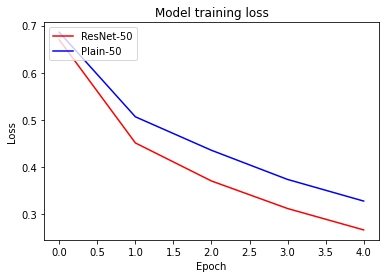

In [34]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50' , 'Plain-50'], loc='upper left')
plt.show()

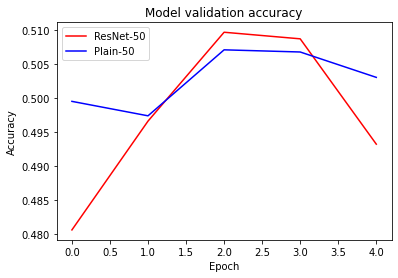

In [35]:
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plain50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50' , 'Plain-50'], loc='upper left')
plt.show()

### (2) ResNet-34  VS Plain-34

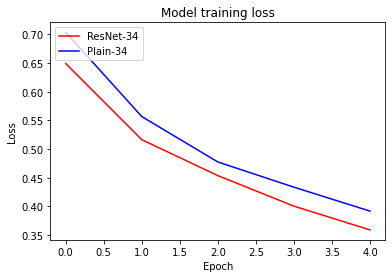

In [36]:
import matplotlib.pyplot as plt

plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_plain34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

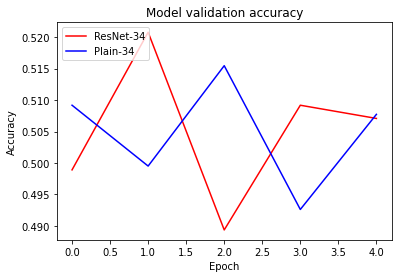

In [37]:
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34' , 'Plain-34'], loc='upper left')
plt.show()

## 회고
### 데이터셋 관련
* `cifar10`-> `cats_vs_dogs`: 레이블의 클래스가 10->2개로 줄어들면서 코드 내에서 변수값을 조정했다. 또, 캣츠앤독스 데이터셋에서 train/test split을 제공하지 않기 때문에 % 로 나누어 설정했다.


### 모델관련
* resnet 논문과 비교하면서 모델을 빌드해보았다. 특히, residual connection을 구현하는 부분을 직접 확인하였고, functional API 형태를 사용하여 모델 구조를 편리하게 확인할 수 있었다.
* 여러 구조의 모델을 사용해야 하기 때문에, 클래스 함수 형태로 만들어 객체화에 유리하도록 작성한 소스를 참고하였다.
* 모델 구조 플롯 keras.utils.plot_model(model, show_shapes=True)


### 학습 관련
* Epoch가 적은 상황이긴 하지만, 전체적으로 Accuracy 가 50% 근처에만 머물러 있다. Loss 가 꾸준히 감소하는 것으로 보았을 때 모델에는 문제가 없는 듯 하고, 레이블 설정에 관련하여 문제가 있어보이지만 아직 해결책을 찾지는 못했다.


### 형식 관련
* Ablation study 형태는 앞으로 논문 작성 등에서 많이 사용할 예정이므로 시나리오에 대해 자세히 살펴보기 좋았다.
* 학습 결과에 대한 평가지표를 플로팅하기위해 keras 내의 metric 목록을 살펴보았다. 차후 custom metric 설정에 대해서 시도해보면 적용해볼 기회가 많을 것 같다.